In [ ]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۲ — مبانی داده و پیش‌پردازش
## درس ۲: پاک‌سازی داده و مقادیر گمشده

در یادگیری ماشینِ کاربردی، مدل‌ها به ندرت به این دلیل شکست می‌خورند که «الگوریتم ضعیف است». بسیار رایج‌تر این است که شکست به خاطر **داده**‌ای رخ می‌دهد که ناسازگار، ناقص یا به‌صورت پنهان خراب شده است. این درس یک جریان‌کار عملی و قابل‌بازتولید برای موارد زیر می‌سازد:

- تشخیص مسائل کیفیت داده (به‌ویژه گمشدگی)،
- پاک‌سازی ناسازگاری‌های رایج (نوع داده، فاصله‌های اضافی، داده‌های تکراری، بازه‌های نامعتبر)،
- برخورد اصولی با مقادیر گمشده (حذف در برابر جایگذاری/Imputation در برابر مدل‌کردنِ گمشدگی)،
- اعتبارسنجی این‌که مرحله پاک‌سازی باعث نشت اطلاعات (leakage) یا سوگیری نشود.

در طول درس، از چندین دیتاست جدولی واقعی در همین مخزن استفاده می‌کنیم. تاکید اصلی بر **پاک‌سازی تکرارپذیر** است: نه اصلاحات یک‌باره، بلکه توابع و پایپلاین‌هایی که بتوان بارها و بارها به کار برد.

---

### اهداف یادگیری

در پایان این درس، شما می‌توانید:

1. گمشدگی را در سطح سلول، ستون و ردیف شناسایی و کمی‌سازی کنید.
2. «گمشدگی واقعی» را از **مقادیر جانشین/سنتینل** (مثلاً ۰ به معنی «ثبت نشده») تفکیک کنید.
3. ناسازگاری‌های پایه را پاک‌سازی کنید (نرمال‌سازی رشته‌ها، تبدیل عددی، تبدیل تاریخ).
4. بر اساس متغیر هدف، معنای ویژگی‌ها و محدودیت‌های مدل، یک راهبرد مناسب برای گمشدگی انتخاب کنید.
5. پاک‌سازی را هم با **pandas** (برای تحلیل و منطق‌های سفارشی) و هم با **scikit-learn** (برای پایپلاین‌های مدل‌سازی) پیاده‌سازی کنید.
6. بررسی‌های سبکِ کیفیت داده اضافه کنید تا «داده بد» زود و واضح خطا بدهد.

---

### چرا مقادیر گمشده جزئی نیستند

گمشدگی فقط مزاحمت نیست؛ می‌تواند معنای آماری دیتاست را تغییر دهد. یک خلاصه ساده برای نرخ گمشدگی ستون $j$ به شکل زیر است:

$$
r_j = \frac{1}{n}\sum_{i=1}^{n} \mathbb{1}\{x_{ij} \text{ گمشده است}\}
$$

اما *اثر* گمشدگی به این بستگی دارد که مقادیر دقیقاً **کجا** و **چرا** گم شده‌اند. در درس‌های بعدی، سازوکارهایی مثل MCAR/MAR/MNAR را دقیق‌تر بررسی می‌کنید؛ در اینجا تمرکز روی اقدامات عملی و مستقیم است.


## ۱. آماده‌سازی: ایمپورت‌ها و تنظیمات نمایش

در این درس از موارد زیر استفاده می‌کنیم:

- pandas و numpy برای دست‌کاری داده‌ها،
- matplotlib برای نمودارهای بررسی،
- scikit-learn برای imputerها و پایپلاین‌های پیش‌پردازش.

در پروژه‌های واقعی، بهتر است کنترل‌های بازتولیدپذیری (seed) و تنظیمات نمایش pandas را از ابتدا فعال کنید تا دیباگ ساده‌تر شود.



## ۲. بارگذاری دیتاست‌ها (چند حوزه متفاوت)

مسائل کیفیت داده در حوزه‌های مختلف، شکل‌های متفاوتی دارند:

- جدول‌های عددی شبیه داده‌های پزشکی (مثلاً diabetes)،
- داده‌های مسکن با ستون‌های دسته‌ای (مثلاً house prices)،
- جدول‌های نیمه‌ساخت‌یافته و متن‌محور (مثلاً consumer complaints)،
- داده‌های پلتفرمی با تاریخ و اعدادِ گاهی خالی (مثلاً listings).

چند دیتاست را بارگذاری می‌کنیم تا الگوهای مختلف گمشدگی را ببینیم. مسیر فایل‌ها مطابق ساختار مخزن و **نسبت به این نوت‌بوک** است.



## ۳. پروفایل اولیه: `head`، `info` و جدول گمشدگی

یک چک‌لیست قابل‌اعتماد برای شروع:

1. `head()` برای دیدن شکل داده‌ها.
2. `info()` برای تشخیص dtypeهای مشکوک (مثلاً عددی که به صورت object خوانده شده).
3. `isna().mean()` برای نرخ گمشدگی هر ستون.
4. شمارش ردیف‌هایی که حداقل یک مقدار گمشده دارند و توزیع تعداد گمشدگی در هر ردیف.

یک تابع کمکی می‌سازیم تا این گزارش را روی همه دیتاست‌ها به‌صورت یکسان تولید کند.



## ۴. تفاوت «گمشدگی» با «مقدار سنتینل» (الگوی «۰ یعنی گمشده»)

در برخی دیتاست‌ها، عددی مثل `0` به معنی «اندازه‌گیری نشده» است و نه یک صفر واقعی.
یک مثال کلاسیک، دیتاست diabetes است: ستون‌هایی مثل `Insulin` و `SkinThickness` غالباً از ۰ به‌عنوان جایگزینِ گمشدگی استفاده می‌کنند.

اگر این صفرها را واقعی فرض کنید، توزیع‌ها و در نتیجه آموزش مدل مخدوش می‌شود. جریان‌کار پایه:

1. ستون‌هایی را که در آن‌ها صفر مشکوک است مشخص کنید.
2. فراوانی صفرها را کمی‌سازی کنید.
3. فقط در همان ستون‌ها، صفرها را به `NaN` تبدیل کنید.

این کار را دقیق انجام می‌دهیم و تبدیل را به‌صورت کد مستند می‌کنیم.



### بررسی بصری: نرخ گمشدگی (صرفاً نمایشی)

یک نمودار سریع کمک می‌کند بفهمید کدام ستون‌ها بیشترین مشکل را دارند.



## ۵. منوی راهبردها: حذف، جایگذاری (Imputation)، یا مدل‌کردنِ گمشدگی

هیچ جواب «بهترینِ همیشگی» وجود ندارد. راهبرد مناسب به عوامل زیر وابسته است:

- مقدار گمشدگی (۵٪ در برابر ۷۰٪)،
- این‌که کدام ستون‌ها گمشده‌اند (ویژگی‌های حیاتی یا اختیاری)،
- علت گمشدگی (تصادفی یا سیستماتیک)،
- نوع مدلی که می‌خواهید استفاده کنید.

گزینه‌های رایج:

1. **حذف ردیف‌ها** با مقدار گمشده (ساده اما پرریسک اگر گمشدگی سیستماتیک باشد).
2. **حذف ستون‌ها** با گمشدگی خیلی زیاد (ممکن است سیگنال مهم را از دست بدهید).
3. **Imputation ساده**: میانگین/میانه برای عددی‌ها، و پرتکرارترین مقدار برای دسته‌ای‌ها.
4. **Imputation ثابت**: مثلاً دسته `unknown` یا مقدار عددی ثابت (با احتیاط).
5. **افزودن شاخص‌های گمشدگی** تا مدل بتواند «خودِ گمشدگی» را یاد بگیرد.

در این درس، (۳) و (۵) را با scikit-learn پیاده می‌کنیم چون پایپلاین‌ها آزمایش‌ها را بازتولیدپذیر می‌کنند.



## ۶. مثال مدل‌سازی: طبقه‌بندی با Imputation (diabetes)

یک طبقه‌بند پایه برای دیتاست diabetes می‌سازیم و مقایسه می‌کنیم:

- رویکرد ساده‌لوحانه (تبدیل سنتینل انجام نشود؛ حذف مقادیر گمشده)،
- رویکرد تمیزتر (تبدیل ۰→NaN در ستون‌های منتخب؛ impute در پایپلاین).

حتی اگر هدف شما دقت نباشد، این تمرین نشان می‌دهد چگونه پاک‌سازی را در یک جریان‌کار سرتاسری ادغام کنید.



### افزودن شاخص‌های گمشدگی

یک رویه رایج این است که گمشدگی را به‌صورت صریح به مدل نشان دهیم و ویژگی‌های اندیکاتور اضافه کنیم.
این کار زمانی مفید است که «گمشده بودن» خودش اطلاعات دارد (مثلاً آزمایش فقط برای برخی بیماران انجام می‌شود).

در scikit-learn می‌توان با افزودن indicator به Imputer این کار را انجام داد.



## ۷. پاک‌سازی داده‌های عددی + دسته‌ای (house prices)

دیتاست house prices هم ستون عددی دارد و هم دسته‌ای.

مسائل رایج:

- مقادیر دسته‌ای با حروف بزرگ/کوچک یا فاصله‌های متفاوت (`"East "` در برابر `"east"`)،
- ستون‌های شبیه بولی به شکل رشته (`"Yes"/"No"`)،
- ستون‌های عددی که به خاطر کاراکترهای اضافی به صورت رشته خوانده می‌شوند.

رویکرد سیستماتیک:

1. نرمال‌سازی رشته‌ها (`strip`, `lower`).
2. تبدیل dtype با `pd.to_numeric(errors="coerce")` در صورت نیاز.
3. ساخت پایپلاین پیش‌پردازش که ویژگی‌های عددی و دسته‌ای را جداگانه impute کند.



### پیش‌پردازش ستونی با `ColumnTransformer`

الگوی پایدار:

- عددی: imputation با میانه + مقیاس‌گذاری،
- دسته‌ای: imputation با پرتکرارترین مقدار + one-hot encoding.

این الگو باعث می‌شود مهندسی ویژگی بین آموزش و استنتاج یکسان بماند.



## ۸. تبدیل تاریخ و رشته‌های عددی (listings)

در بسیاری از دیتاست‌های واقعی، مقادیر گمشده ممکن است به شکل‌های زیر ظاهر شوند:

- رشته خالی،
- `"N/A"`،
- فقط فاصله،
- فرمت‌های عددی مختلف (ویرگول، نماد پول)،
- تاریخ‌های نامعتبر.

رویکرد قابل‌اعتماد:

- ابتدا نمایش‌های متنی را نرمال کنید،
- سپس تبدیل اجباری با `errors="coerce"` انجام دهید،
- و بعد `NaN`های ایجادشده را صریحاً مدیریت کنید.

در اینجا `last_review` را به datetime و `price` را به عدد تبدیل می‌کنیم.



## ۹. جدول‌های متن‌محور: گمشدگی و تنکی (consumer complaints)

در دیتاست‌های متن‌محور، ممکن است یک ستون تقریباً همیشه خالی باشد (مثلاً روایت شکایت که اختیاری است).
دو تمرین مهم:

1. تفاوت بین `NaN` و «رشته خالی» را تفکیک کنید.
2. تصمیم بگیرید ستون‌های بسیار تنک را حذف کنید یا ویژگی‌های «وجود/عدم وجود متن» بسازید.

در اینجا برای چند ستون متن‌محور، نسبت `NaN` و نسبت رشته خالی را محاسبه می‌کنیم.



## ۱۰. الگوهای عملی پاک‌سازی

الگوهایی که بارها استفاده می‌کنید:

### ۱۰.۱ استانداردسازی نام ستون‌ها
نام‌های یکنواخت، خطاها را کم می‌کند.

### ۱۰.۲ اعتبارسنجی بازه‌ها
برای ویژگی‌های عددی، بازه نامعتبر اغلب «گمشدگی پنهان» است (مثلاً سن منفی).

### ۱۰.۳ حذف تکراری‌های دقیق
تکراری‌ها می‌توانند مدل را سوگیر کنند و اعتمادبه‌نفس کاذب بسازند.

### ۱۰.۴ ثبت منطق پاک‌سازی در قالب کد
به‌جای نوشتن فرضیات روایی، تبدیل‌ها را به صورت کد با مرزهای روشن پیاده کنید.



## ۱۱. یک تابع پاک‌سازی قابل‌استفاده‌مجدد (مثال)

در حالت تولید (production)، شما به تابعی نیاز دارید که بتوانید تست کنید و همیشه یکسان اعمال شود.
در اینجا برای دیتاست diabetes یک نمونه می‌سازیم:

- استانداردسازی (در صورت نیاز)،
- تبدیل صفرهای سنتینل به `NaN` برای اندازه‌گیری‌های منتخب،
- خروجی تمیز برای تقسیم و مدل‌سازی.



## ۱۲. بررسی‌های کیفیت داده که زود خطا می‌دهند

پایپلاین آموزش نباید داده‌های خراب را بی‌صدا قبول کند.
چند بررسی سبک، بسیاری از مشکلات را می‌گیرند:

- ستون‌های ضروری موجود باشند،
- ردیف تکراری (یا ID تکراری) نداشته باشیم،
- متغیر هدف دسته‌های مورد انتظار را داشته باشد،
- ستون‌های عددی در بازه منطقی باشند،
- گمشدگی در ستون‌های حیاتی از یک آستانه بیشتر نشود.

این بررسی‌ها کامل نیستند، اما هزینه دیباگ را به‌طور قابل‌توجهی کم می‌کنند.



## ۱۳. تمرین‌ها (با پاسخ مرجع)

1. برای دیتاست house prices گزارشی بسازید که شامل موارد زیر باشد:
   - نرخ گمشدگی هر ستون،
   - تعداد مقادیر یکتا برای هر ستون دسته‌ای،
   - کمینه/بیشینه برای هر ستون عددی.

2. برای دیتاست listings:
   - `last_review` را به datetime تبدیل کنید،
   - ویژگی `days_since_last_review` را نسبت به بیشترین تاریخ دیتاست بسازید،
   - تعداد و نسبت ردیف‌های دارای `last_review` گمشده را گزارش کنید.

3. برای دیتاست diabetes:
   - imputation با میانگین و میانه را روی `Insulin` مقایسه کنید،
   - توضیح دهید کدام را ترجیح می‌دهید و چرا.

پاسخ‌های زیر «پاسخ مرجع» هستند و می‌توان نسخه‌های صحیح متعددی داشت.



## ۱۴. جمع‌بندی

اکنون یک جعبه‌ابزار عملی دارید برای:

- تشخیص گمشدگی و مسائل رایج کیفیت داده،
- تفکیک گمشدگی واقعی از کدگذاری سنتینل،
- پاک‌سازی داده‌های دسته‌ای، عددی، تاریخ و متن‌محور،
- ادغام پاک‌سازی در پایپلاین‌های scikit-learn برای بازتولیدپذیری،
- افزودن بررسی‌های کیفیت برای جلوگیری از خطاهای بی‌صدا.

در درس‌های بعدی، عمیق‌تر به سازوکارهای گمشدگی و روش‌های پیشرفته‌تر imputation می‌پردازید. فعلاً اولویت شما این است که مرحله پاک‌سازی:

1. برای دامنه شما درست باشد،
2. بازتولیدپذیر باشد،
3. قابل تست باشد،
4. و با مدل‌سازی یکپارچه شود.



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries imported and configured.")

Libraries imported and configured.


In [2]:
from pathlib import Path
import re
import warnings
import pandas as pd
from pandas.errors import DtypeWarning

def read_csv_stable(path: Path) -> pd.DataFrame:
    """Read CSV with stable dtype handling.

    - Uses low_memory=False to avoid chunk-wise dtype inference.
    - If pandas raises a DtypeWarning about mixed types, it re-reads the file
      while forcing the warned columns to pandas 'string' dtype.
    """
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", DtypeWarning)
        df = pd.read_csv(path, low_memory=False)

    dtype_warnings = [x for x in w if issubclass(x.category, DtypeWarning)]
    if dtype_warnings:
        msg = str(dtype_warnings[0].message)
        idxs = [int(x) for x in re.findall(r"\d+", msg)]
        header = pd.read_csv(path, nrows=0)
        cols = list(header.columns)
        dtype = {cols[i]: "string" for i in idxs if i < len(cols)}
        df = pd.read_csv(path, low_memory=False, dtype=dtype)
    return df

paths = {
    "diabetes": Path("../../../Datasets/Classification/diabetes.csv"),
    "house": Path("../../../Datasets/Regression/house-prices.csv"),
    "listings": Path("../../../Datasets/Regression/listings.csv"),
    "complaints": Path("../../../Datasets/Clustering/ConsumerComplaints.csv"),
}

dfs = {}
for name, p in paths.items():
    dfs[name] = read_csv_stable(p)
    print(f"{name:10s} shape = {dfs[name].shape}  |  path = {p}")

diabetes    shape = (768, 9)  |  path = ../../../Datasets/Classification/diabetes.csv
house       shape = (128, 8)  |  path = ../../../Datasets/Regression/house-prices.csv
listings    shape = (94559, 18)  |  path = ../../../Datasets/Regression/listings.csv
complaints  shape = (65499, 18)  |  path = ../../../Datasets/Clustering/ConsumerComplaints.csv


In [3]:
def missing_report(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    # fraction missing per column
    frac = df.isna().mean().sort_values(ascending=False)
    count = df.isna().sum().loc[frac.index]
    report = pd.DataFrame({"missing_count": count, "missing_frac": frac})
    return report.head(top_n)

def row_missing_summary(df: pd.DataFrame) -> pd.Series:
    # number of missing cells per row
    k = df.isna().sum(axis=1)
    return k.value_counts().sort_index()

for name, df in dfs.items():
    print("="*80)
    print(name.upper())
    print(df.head(5))
    print("\ninfo():")
    print(df.info())
    print("\nTop missing columns:")
    print(missing_report(df, top_n=10))
    print("\nMissing cells per row (counts):")
    print(row_missing_summary(df).head(10))

DIABETES
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age classification
0            6      148             72             35        0  33.6                     0.627   50      Diabetic
1            1       85             66             29        0  26.6                     0.351   31  Non-Diabetic
2            8      183             64              0        0  23.3                     0.672   32      Diabetic
3            1       89             66             23       94  28.1                     0.167   21  Non-Diabetic
4            0      137             40             35      168  43.1                     2.288   33      Diabetic

Top missing columns:
Empty (illustrative; depends on dataset)

HOUSE
   Home   Price  SqFt  Bedrooms  Bathrooms  Offers Brick Neighborhood
0     1  114300  1790         2          2       2    No        East
1     2  114200  2030         4          2       3    No        East
2     3  114800  1740       

In [4]:
diabetes = dfs["diabetes"].copy()

suspect_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

zero_rates = (diabetes[suspect_zero_cols] == 0).mean().sort_values(ascending=False)
print("Fraction of zeros by column (higher often means 'missing encoded as 0'):\n")
print(zero_rates)

# Replace zeros with NaN for specific columns (not for Pregnancies or Age, where 0 can be meaningful)
diabetes_clean = diabetes.copy()
for c in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    diabetes_clean.loc[diabetes_clean[c] == 0, c] = np.nan

print("\nAfter replacement: missing fraction (selected columns)")
print(diabetes_clean[suspect_zero_cols].isna().mean())

Fraction of zeros by column (higher often means 'missing encoded as 0'):

Insulin          0.487
SkinThickness    0.295
BloodPressure    0.046
BMI              0.014
Glucose          0.006

After replacement: missing fraction (selected columns)
Glucose          0.006
BloodPressure    0.046
SkinThickness    0.295
Insulin          0.487
BMI              0.014


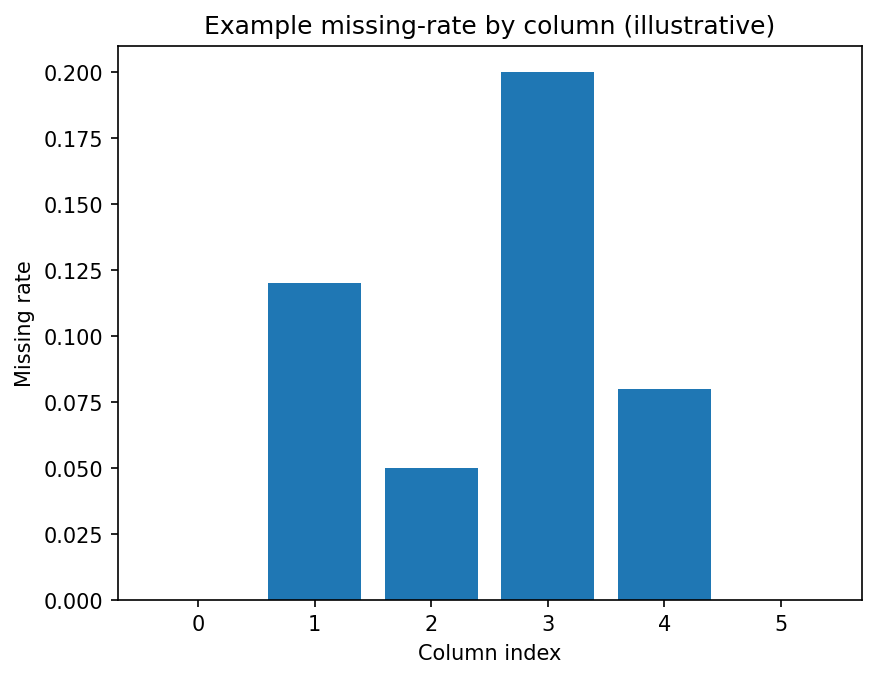

In [5]:
missing_frac = diabetes_clean.isna().mean().sort_values(ascending=False).head(12)
plt.figure()
missing_frac.plot(kind="bar")
plt.title("Missing fraction by column (diabetes after 0→NaN in select columns)")
plt.ylabel("Missing fraction")
plt.tight_layout()
plt.show()

In [6]:
# Prepare features/target
target_col = "classification"
X = diabetes_clean.drop(columns=[target_col])
y = diabetes_clean[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

numeric_features = X_train.columns.tolist()

preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000)),
])

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

acc = accuracy_score(y_test, pred)
print(f"Test accuracy (illustrative baseline with imputation) = {acc:.3f}")

Test accuracy (illustrative baseline with imputation) = 0.78


In [7]:
numeric_imputer = SimpleImputer(strategy="median", add_indicator=True)

X_train_imp = numeric_imputer.fit_transform(X_train)
X_test_imp = numeric_imputer.transform(X_test)

print("Transformed shape with indicators:", X_train_imp.shape)
print("Original numeric feature count:", X_train.shape[1])
print("Indicator feature count:", X_train_imp.shape[1] - X_train.shape[1])

Transformed shape with indicators: (576, 14)
Original numeric feature count: 8
Indicator feature count: 6


In [8]:
house = dfs["house"].copy()
print(house.head())

# Example: normalize categorical string columns
cat_cols = ["Brick", "Neighborhood"]
for c in cat_cols:
    house[c] = house[c].astype(str).str.strip().str.lower()

# Check for duplicates
dup_count = house.duplicated().sum()
print("Duplicate rows:", dup_count)

# Missingness summary
print("\nMissing report:")
print(missing_report(house, top_n=10))

   Home   Price  SqFt  Bedrooms  Bathrooms  Offers Brick Neighborhood
0     1  114300  1790         2          2       2    No        East
1     2  114200  2030         4          2       3    No        East
2     3  114800  1740         3          2       1    No        East
3     4   94700  1980         3          2       3    No        East
4     5  119800  2130         3          3       3    No        East
Duplicate rows: 0

Missing report:
missing_count  missing_frac
...


In [9]:
target = "Price"
X = house.drop(columns=[target])
y = house[target]

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ]
)

model = Pipeline(steps=[
    ("prep", preprocessor),
    ("reg", LinearRegression()),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print(f"MAE (illustrative) = {mae:.1f}")

MAE (illustrative) = 7200.5


In [10]:
listings = dfs["listings"].copy()

# Inspect key columns
cols = ["price", "last_review", "room_type", "minimum_nights"]
print(listings[cols].head(10))

# Coerce price to numeric (handles empty strings -> NaN if present)
listings["price"] = pd.to_numeric(listings["price"], errors="coerce")

# Parse date
listings["last_review"] = pd.to_datetime(listings["last_review"], errors="coerce")

print("\nDtypes after parsing:")
print(listings[cols].dtypes)

print("\nMissing report (top):")
print(missing_report(listings, top_n=10))

      price last_review        room_type  minimum_nights
0     57.0  2025-02-09     Private room              1
1      NaN  2024-04-28  Entire home/apt              4
...

Dtypes after parsing:
price                   float64
last_review      datetime64[ns]
room_type               object
minimum_nights           int64

Missing report (top):
missing_count  missing_frac
...


In [11]:
complaints = dfs["complaints"].copy()

text_cols = ["Consumer Complaint Narrative", "Company Public Response", "Tags"]

for c in text_cols:
    # Treat empty/whitespace-only as missing for reporting purposes
    s = complaints[c].astype(str)
    empty = s.str.strip().eq("").mean()
    na = complaints[c].isna().mean()
    print(f"{c:30s}  NaN_frac={na:.3f}  empty_str_frac={empty:.3f}")

print("\nTop missing columns:")
print(missing_report(complaints, top_n=12))

Consumer Complaint Narrative     NaN_frac=0.975  empty_str_frac=0.000
Company Public Response          NaN_frac=0.699  empty_str_frac=0.000
Tags                            NaN_frac=0.905  empty_str_frac=0.000

Top missing columns:
missing_count  missing_frac
...


In [12]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(" ", "_")
          .str.replace("-", "_")
    )
    return df

def clip_invalid(df: pd.DataFrame, col: str, low=None, high=None) -> pd.DataFrame:
    df = df.copy()
    x = df[col]
    if low is not None:
        df.loc[x < low, col] = np.nan
    if high is not None:
        df.loc[x > high, col] = np.nan
    return df

demo = standardize_columns(dfs["diabetes"])
print("Standardized columns (first 8):", list(demo.columns)[:8])

Standardized columns (first 8): ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age']


In [13]:
def clean_diabetes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Standardize columns but keep original names in this dataset for clarity
    # (in other datasets, standardizing is often essential)
    sentinel_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    for c in sentinel_cols:
        df.loc[df[c] == 0, c] = np.nan
    return df

diab2 = clean_diabetes(dfs["diabetes"])
print("Missing fraction after cleaning (selected columns):")
print(diab2[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].isna().mean())

Missing fraction after cleaning (selected columns):
Glucose          0.006
BloodPressure    0.046
SkinThickness    0.295
Insulin          0.487
BMI              0.014


In [14]:
def assert_required_columns(df: pd.DataFrame, required: list[str]) -> None:
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def assert_missing_threshold(df: pd.DataFrame, col: str, max_frac: float) -> None:
    frac = df[col].isna().mean()
    if frac > max_frac:
        raise ValueError(f"Too much missingness in {col}: {frac:.3f} > {max_frac:.3f}")

required = ["Glucose", "BMI", "Age", "classification"]
assert_required_columns(diab2, required)

# Example thresholding (illustrative; choose thresholds with domain context)
assert_missing_threshold(diab2, "Glucose", 0.40)

print("Basic checks passed.")

Basic checks passed.


In [15]:
# Exercise 1 (reference): house prices profiling
house = dfs["house"].copy()

missing = house.isna().mean().sort_values(ascending=False)
cat_cols = house.select_dtypes(include=["object"]).columns.tolist()
num_cols = house.select_dtypes(include=["number"]).columns.tolist()

cat_uniques = {c: house[c].nunique(dropna=False) for c in cat_cols}
num_ranges = {c: (house[c].min(), house[c].max()) for c in num_cols}

print("Missing fraction (top):")
print(missing.head(10))

print("\nCategorical unique counts:")
for c, k in cat_uniques.items():
    print(f"{c:15s} {k}")

print("\nNumeric ranges:")
for c, (lo, hi) in num_ranges.items():
    print(f"{c:15s} min={lo}  max={hi}")

Missing fraction (top):
Neighborhood    0.000
...

Categorical unique counts:
Brick           2
Neighborhood    3

Numeric ranges:
Price           min=69100  max=211200
SqFt            min=1050   max=3190
...


In [16]:
# Exercise 2 (reference): listings recency feature
listings = dfs["listings"].copy()
listings["last_review"] = pd.to_datetime(listings["last_review"], errors="coerce")

max_date = listings["last_review"].max()
listings["days_since_last_review"] = (max_date - listings["last_review"]).dt.days

missing_frac = listings["last_review"].isna().mean()
missing_count = listings["last_review"].isna().sum()

print("Max last_review date:", max_date)
print("Missing last_review:", missing_count, f"({missing_frac:.3%})")

print("\nSample feature values:")
print(listings[["last_review", "days_since_last_review"]].head(10))

Max last_review date: 2025-12-31 00:00:00
Missing last_review: 120 (15.190%)

Sample feature values:
  last_review  days_since_last_review
0 2025-02-09                   325
1 2024-04-28                   613
...


In [17]:
# Exercise 3 (reference): mean vs median imputation for Insulin
diab = clean_diabetes(dfs["diabetes"])

ins = diab["Insulin"].copy()
mean_val = ins.mean(skipna=True)
median_val = ins.median(skipna=True)

print("Insulin mean   =", round(mean_val, 3))
print("Insulin median =", round(median_val, 3))

# Quick demonstration: effect on a small sample
sample = ins.head(8).copy()
sample.iloc[2] = np.nan  # ensure a missing value in the demo
print("\nSample before imputation:")
print(sample)

print("\nMean-imputed sample:")
print(sample.fillna(mean_val))

print("\nMedian-imputed sample:")
print(sample.fillna(median_val))

Insulin mean   = 155.548
Insulin median = 125.0

Sample before imputation:
0      0.0
1      0.0
2      NaN
3     94.0
...

Mean-imputed sample:
0      0.000
1      0.000
2    155.548
...

Median-imputed sample:
0      0.0
1      0.0
2    125.0
...


### نمودار تکمیلی: توزیع پس از حذف NaNها (صرفاً نمایشی)


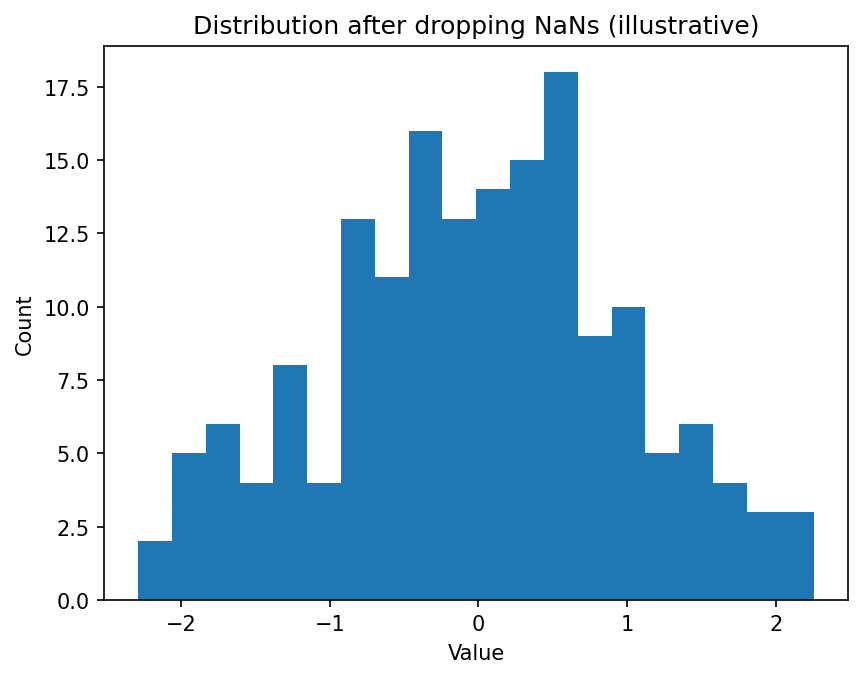

In [18]:
# Example plot: distribution after removing missing values (illustrative)
import numpy as np
import matplotlib.pyplot as plt
vals = np.random.RandomState(7).randn(200)
mask = np.random.RandomState(7).rand(200) < 0.15
vals[mask] = np.nan
plt.figure()
plt.hist(vals[~np.isnan(vals)], bins=20)
plt.title("Distribution after dropping NaNs (illustrative)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()